# Natural Language Processing with neural networks

In this notebook i'll looking at some techniques for language processing with neural networks. There is multiple way to rome so it's nice to show some approaches.

Also i personally was interested to see what things works - and what things work best. So i'll share some things that i have learned...

In [ ]:
!pip install --upgrade numpy keras tensorflow

## Dataset & preprocessing

First things i'm doing is load and preprocess a dataset. I'm using the imdb movie reviews example dataset from keras.

The dataset has the review text encoded as sequences, that is arrays of numbers. Preprocessing here means padding all sequences to be the same length so they can be fed into a neural network.

In [2]:
## From https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py

max_features = 20000
maxlen = 80
epochs = 8

In [3]:
from keras.datasets import imdb

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

print(x_train.shape)
print(x_test.shape)

Using TensorFlow backend.


17465344/17464789 [==============================] - 3s 0us/step
(25000,)
(25000,)


In [4]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(25000, 80)
(25000, 80)


## Network architectures

Next up we'll try some different network architectues, a CNN and a LSTM.

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Conv1D, GlobalMaxPool1D, Flatten

def build_dense_model(dropout=0.25):
    model = Sequential()
    model.add(Embedding(max_features, 32, input_length=maxlen))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_lstm_model(dropout=0.4):
    model = Sequential()
    model.add(Embedding(max_features, 32, input_length=maxlen))
    model.add(LSTM(64))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_cnn_model(dropout=0.25):
    model = Sequential()
    model.add(Embedding(max_features, 32, input_length=maxlen))
    model.add(Dropout(dropout))
    model.add(Conv1D(filters=64, kernel_size=7, padding='same', activation='relu'))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Batch size and epochs

First thing i'm curious about with these models - for how many epochs should we train the models? When will they start to overfit? And what effect does batch size have on this?

I'm going to train the models with different settings and plot the train/validation curves to see the effects.

In [23]:
history_1000 = build_lstm_model().fit(x_train, y_train, batch_size=1000, epochs=epochs,
                                      validation_data=(x_test, y_test), verbose=0)

In [24]:
history_500 = build_lstm_model().fit(x_train, y_train, batch_size=500, epochs=epochs,
                                     validation_data=(x_test, y_test), verbose=0)

In [25]:
history_250 = build_lstm_model().fit(x_train, y_train, batch_size=250, epochs=epochs,
                                     validation_data=(x_test, y_test), verbose=0)

In [26]:
history_100 = build_lstm_model().fit(x_train, y_train, batch_size=100, epochs=epochs,
                                     validation_data=(x_test, y_test), verbose=0)

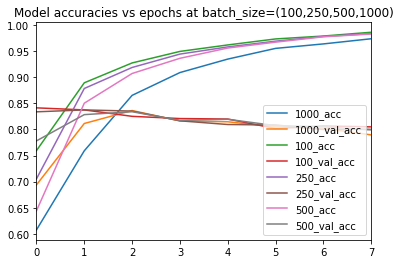

In [27]:
import pandas as pd
%matplotlib inline

df = pd.DataFrame({
    '1000_acc': history_1000.history['acc'],
    '1000_val_acc': history_1000.history['val_acc'],
    '500_acc': history_500.history['acc'],
    '500_val_acc': history_500.history['val_acc'],
    '250_acc': history_250.history['acc'],
    '250_val_acc': history_250.history['val_acc'],
    '100_acc': history_100.history['acc'],
    '100_val_acc': history_100.history['val_acc'],
})

df.plot(title='Model accuracies vs epochs at batch_size=(100,250,500,1000)')

In [30]:
print("Max accuracy at batch {:>4d} : {:.4f}".format(100, max(history_100.history['val_acc'])))
print("Max accuracy at batch {:>4d} : {:.4f}".format(250, max(history_250.history['val_acc'])))
print("Max accuracy at batch {:>4d} : {:.4f}".format(500, max(history_500.history['val_acc'])))
print("Max accuracy at batch {:>4d} : {:.4f}".format(1000, max(history_1000.history['val_acc'])))

Max accuracy at batch  100 : 0.8412
Max accuracy at batch  250 : 0.8372
Max accuracy at batch  500 : 0.8338
Max accuracy at batch 1000 : 0.8360


So what we can learn from the above:

* With smaller batches, we need less epochs to learn from the data
* During training, accuracy first increases, then reaches a peak and finally decreases again (overfitting)

So to get best results, we should always finetune epochs and batch size to get best results.

## Comparing the different architectures

Next thing i'm curious about - how does performance go between the different neural network architectures? Which works best?

In [39]:
history_dense = build_dense_model().fit(x_train, y_train, batch_size=1000, epochs=epochs,
                                        validation_data=(x_test, y_test), verbose=0)

In [40]:
history_lstm = build_lstm_model().fit(x_train, y_train, batch_size=1000, epochs=epochs,
                                      validation_data=(x_test, y_test), verbose=0)

In [41]:
history_cnn = build_cnn_model().fit(x_train, y_train, batch_size=1000, epochs=epochs,
                                    validation_data=(x_test, y_test), verbose=0)

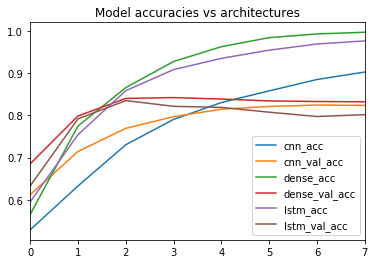

In [42]:
df = pd.DataFrame({
    'dense_acc': history_dense.history['acc'],
    'dense_val_acc': history_dense.history['val_acc'],
    
    'lstm_acc': history_lstm.history['acc'],
    'lstm_val_acc': history_lstm.history['val_acc'],
    
    'cnn_acc': history_cnn.history['acc'],
    'cnn_val_acc': history_cnn.history['val_acc'],
})

df.plot(title='Model accuracies vs architectures')

In [44]:
print("Max validation accuracy [{:>5s}] : {:.4f}".format('dense', max(history_dense.history['val_acc'])))
print("Max validation accuracy [{:>5s}] : {:.4f}".format('lstm', max(history_lstm.history['val_acc'])))
print("Max validation accuracy [{:>5s}] : {:.4f}".format('cnn', max(history_cnn.history['val_acc'])))

Max validation accuracy [dense] : 0.8421
Max validation accuracy [ lstm] : 0.8350
Max validation accuracy [  cnn] : 0.8244


What can we learn from the above? While all similar in performance, there is definitely differences. The current configuration of CNN for example doesn't seem to work as well, or needs more training iterarions.

## How much dropout?

Next and final thing i'm curious about, how much dropout to apply? And one large final dropout layer vs multiple smaller in-between dropout layers?

Let's have a look!

In [45]:
history_0_5 = build_lstm_model(dropout=0.5).fit(x_train, y_train, batch_size=1000, epochs=epochs,
                                                validation_data=(x_test, y_test), verbose=0)

In [46]:
history_0_25 = build_lstm_model(dropout=0.25).fit(x_train, y_train, batch_size=1000, epochs=epochs,
                                                validation_data=(x_test, y_test), verbose=0)

In [47]:
history_0 = build_lstm_model(dropout=0.0).fit(x_train, y_train, batch_size=1000, epochs=epochs,
                                                validation_data=(x_test, y_test), verbose=0)

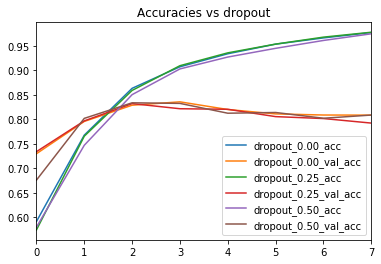

In [48]:
df = pd.DataFrame({
    'dropout_0.50_acc': history_0_5.history['acc'],
    'dropout_0.50_val_acc': history_0_5.history['val_acc'],
    
    'dropout_0.25_acc': history_0_25.history['acc'],
    'dropout_0.25_val_acc': history_0_25.history['val_acc'],
    
    'dropout_0.00_acc': history_0.history['acc'],
    'dropout_0.00_val_acc': history_0.history['val_acc'],
})

df.plot(title='Accuracies vs dropout')

In [49]:
print("Max validation accuracy [dropout={:.2f}] : {:.4f}".format(0.5, max(history_0_5.history['val_acc'])))
print("Max validation accuracy [dropout={:.2f}] : {:.4f}".format(0.25, max(history_0_25.history['val_acc'])))
print("Max validation accuracy [dropout={:.2f}] : {:.4f}".format(0.0, max(history_0.history['val_acc'])))

Max validation accuracy [dropout=0.50] : 0.8339
Max validation accuracy [dropout=0.25] : 0.8323
Max validation accuracy [dropout=0.00] : 0.8359


So what can we learn?

* Apparently dropout has very little effect on the final model accuracy
* Training with dropout does seem to take a little longer to reach best performance

So with this model and this dataset - it seems to have little benefit..

## Conclusions

For the moment i'm going to leave this at the findings above. We've seen the effects of some parameters - mainly it makes sense to try out different things to find a good working combination!